In [1]:
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
import jax.numpy as jnp
import optax
import flax
from flax.training import train_state, checkpoints

print(f"JAX devices:{jax.devices()}")

from dataset.chirping_binary import ChirpingBinary
from models.signalprocessing import SaShiMi, Mamba
import training

JAX devices:[cuda(id=0)]


In [2]:
rng_key = jax.random.key(0)
dataset = ChirpingBinary(
    n_sources=4,
    duration_s=2**12 / 1000,
    sample_rate_Hz=1000,
    scale=1e20,
)
print(f"episode length: {dataset.duration_s} s, samples: {int(dataset.duration_s * dataset.sample_rate_Hz)}")
model = Mamba(stages=3, stage_layers=3 , hidden_channels=32, hidden_state_dim=64)
print(model.tabulate(rng_key, dataset.sample(rng_key)[0], depth=1))

episode length: 4.096 s, samples: 4096

                                 Mamba Summary                                  
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module     ┃ inputs         ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ Mamba      │ float32[4096,… │ float32[4096,… │               │
├───────────────┼────────────┼────────────────┼────────────────┼───────────────┤
│ Dense_0       │ Dense      │ float32[4096,… │ float32[4096,… │ kernel:       │
│               │            │                │                │ float32[2,32] │
│               │            │                │                │               │
│               │            │                │                │ 64 (256 B)    │
├───────────────┼────────────┼────────────────┼────────────────┼───────────────┤
│ MambaBlock_0  │ MambaBlock │ float32[4096,… │ float32[4096,… │ 18,7

In [3]:
optimization_step = jax.jit(partial(training.optimization_step, loss_fn=training.signal_mse_loss))
get_batch = jax.jit(dataset.get_batch, static_argnames="batch_size")
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(rng_key, dataset.sample(rng_key)[0]),
    tx=optax.chain(optax.clip(1.0), optax.adam(1e-3, b2=0.95)),
)

In [ ]:
N_epochs = 100
batches_per_epoch = 100
batch_size = 8

for epoch_idx, epoch_rng_key in enumerate(pbar:=tqdm(jax.random.split(rng_key, N_epochs))):
    losses = []
    for batch_rng_key in tqdm(jax.random.split(epoch_rng_key, batches_per_epoch), leave=False):
        x, y = get_batch(batch_rng_key, batch_size)
        state, loss_value = optimization_step(state, x, y)
        losses.append(loss_value)
    checkpoints.save_checkpoint(ckpt_dir=os.getcwd()+"/checkpoints", target=state, step=epoch_idx, overwrite=True)
    pbar.set_description(f"epoch avg loss: {round(float(sum(losses) / len(losses)), 4)}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.020522406


  0%|          | 0/1 [00:00<?, ?it/s]

0.053497363


  0%|          | 0/1 [00:00<?, ?it/s]

0.01874227


  0%|          | 0/1 [00:00<?, ?it/s]

0.024932737


  0%|          | 0/1 [00:00<?, ?it/s]

0.016671944


  0%|          | 0/1 [00:00<?, ?it/s]

0.02523008


  0%|          | 0/1 [00:00<?, ?it/s]

0.021954155


  0%|          | 0/1 [00:00<?, ?it/s]

0.028954389


  0%|          | 0/1 [00:00<?, ?it/s]

0.0190421


  0%|          | 0/1 [00:00<?, ?it/s]

0.027184032


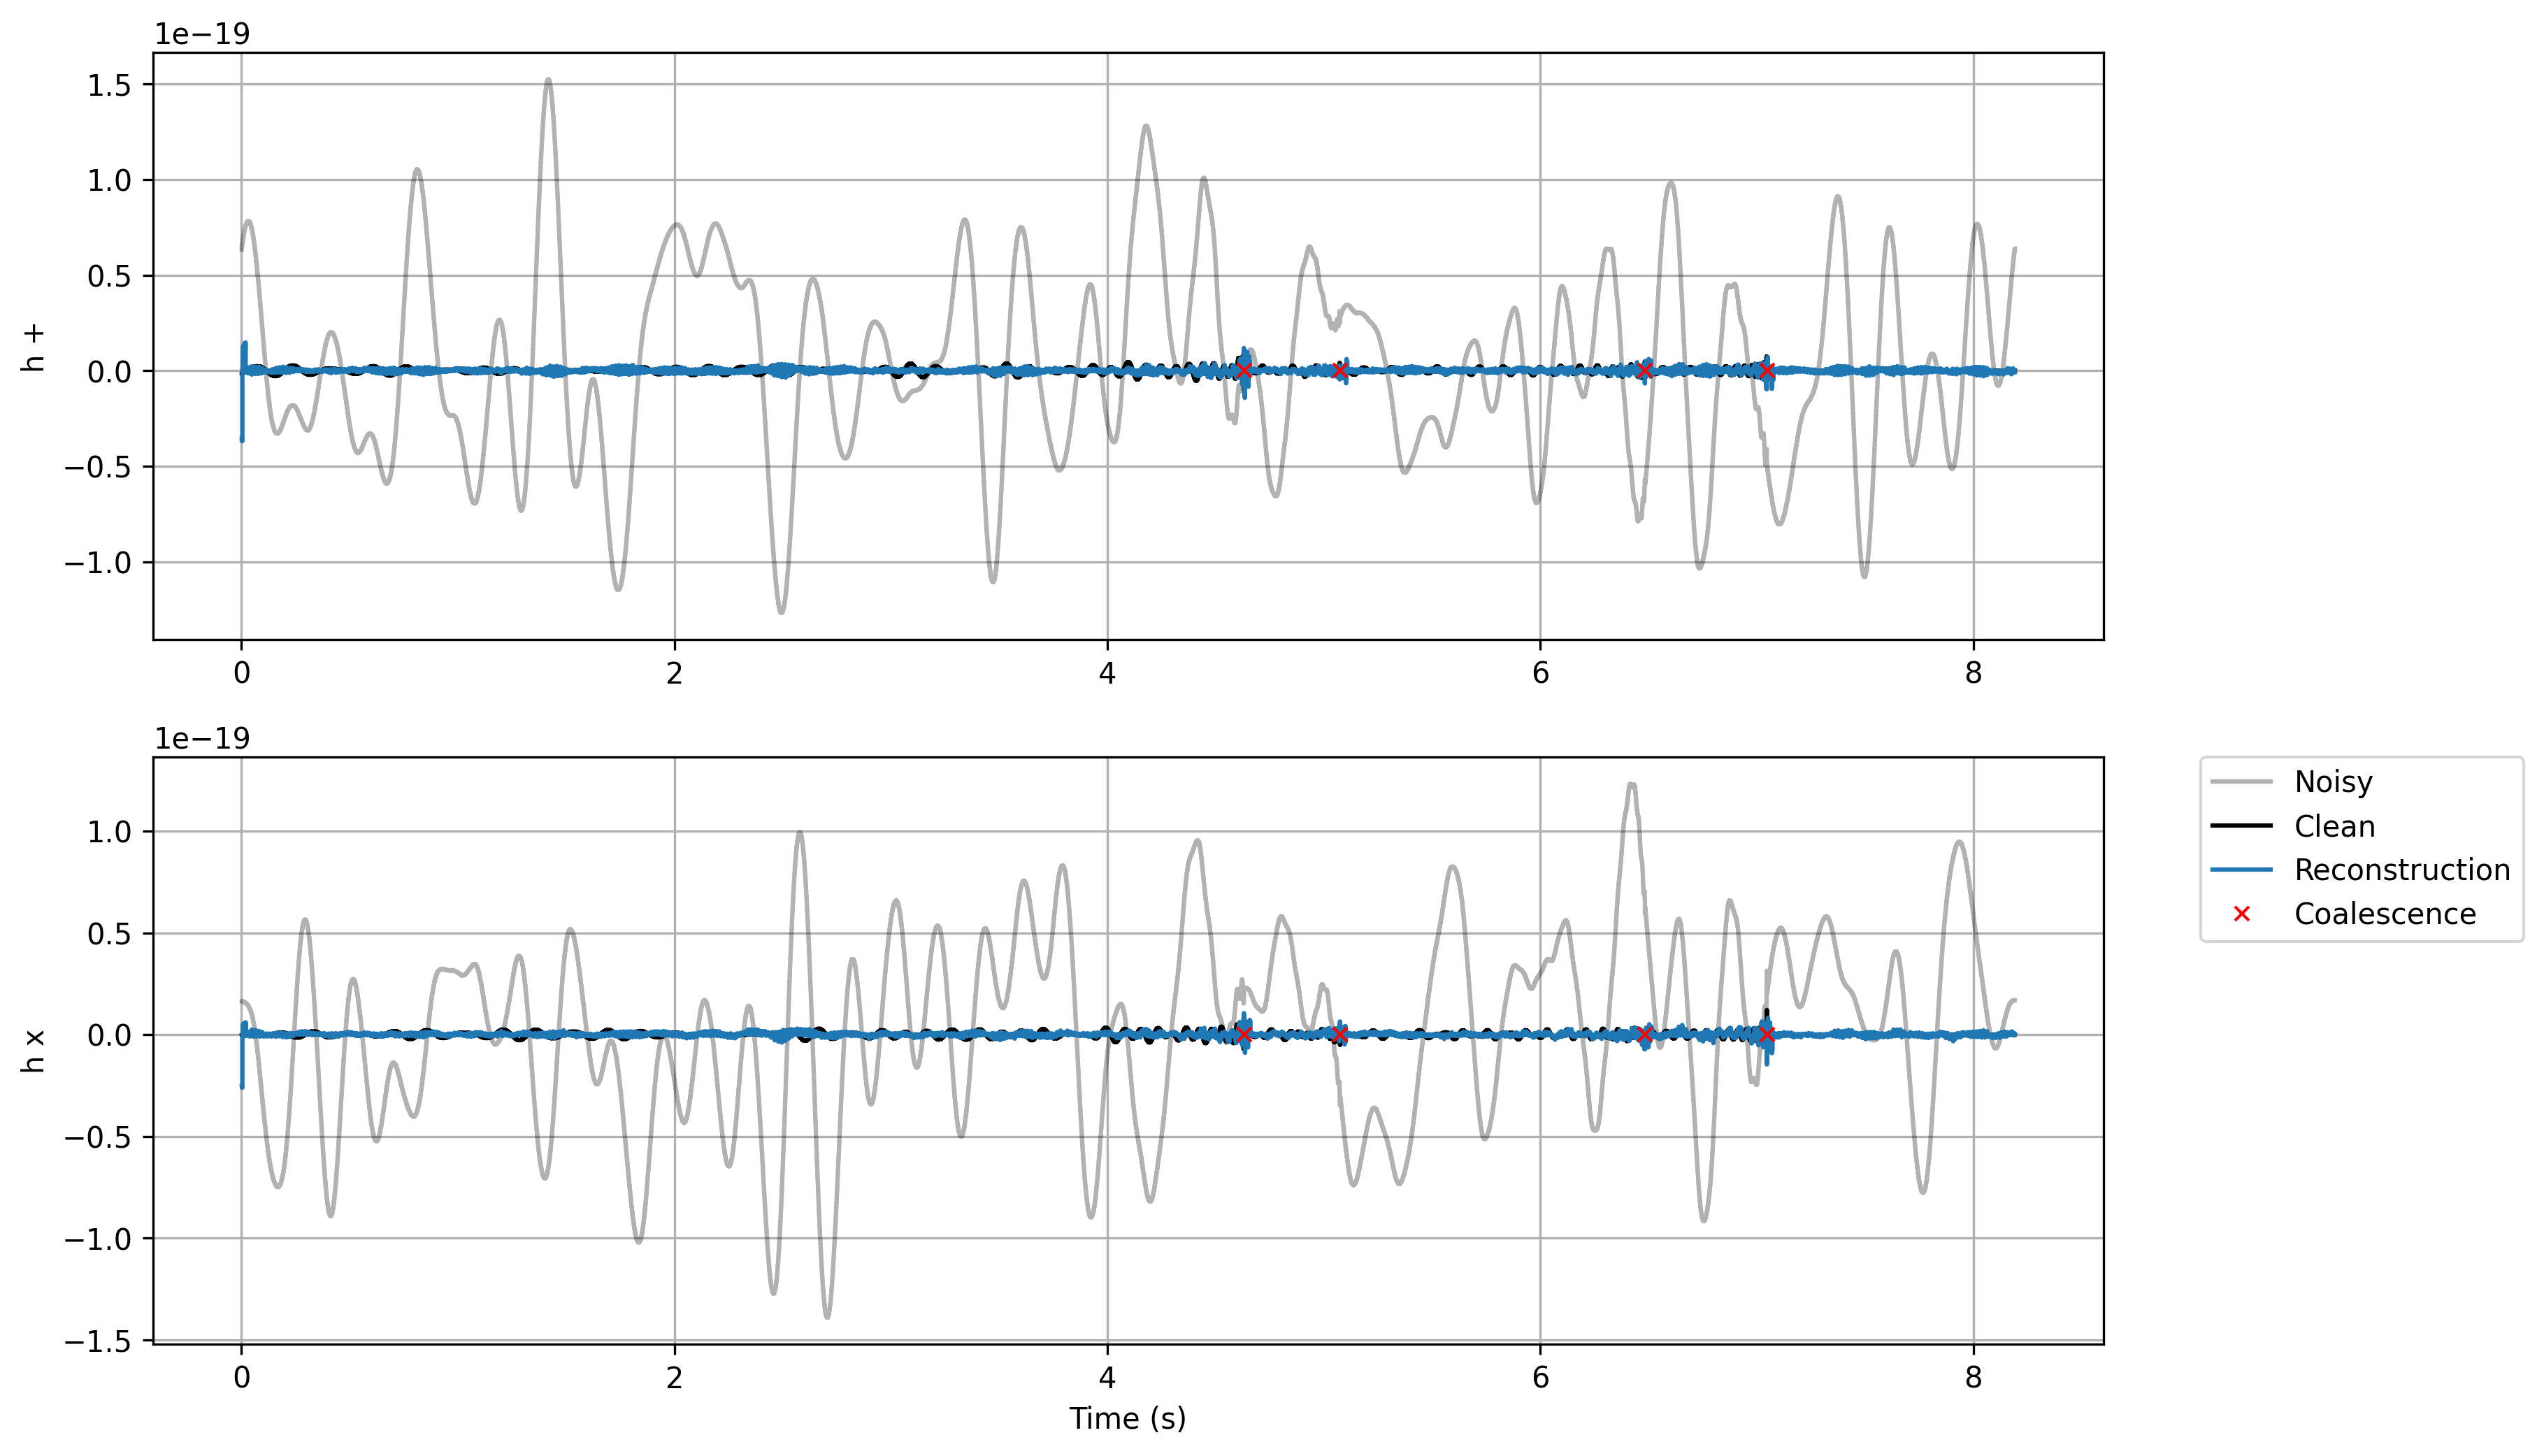

In [ ]:
rng_key, subkey = jax.random.split(rng_key) 
x, y, p = dataset.sample(subkey)
out = state.apply_fn(state.params, x)
plt.figure(figsize=(12, 8), dpi=300)
plt.subplot(2, 1, 1)
plt.step(dataset.times, 1e-20*x[:, 0], "k", label="Noisy", alpha=0.3)
plt.step(dataset.times, 1e-20*y[:, 0], "k", label="Clean")
plt.step(dataset.times, 1e-20*out[:, 0], "tab:blue", label="Reconstruction")
plt.plot(p.tcoal_s, jnp.zeros_like(p.tcoal_s), "rx", markersize=5, label="Coalescence")
plt.ylabel("h +")
plt.grid()
plt.subplot(2, 1, 2)
plt.step(dataset.times, 1e-20*x[:, 1], "k", label="Noisy", alpha=0.3)
plt.step(dataset.times, 1e-20*y[:, 1], "k", label="Clean")
plt.step(dataset.times, 1e-20*out[:, 1], "tab:blue", label="Reconstruction")
plt.plot(p.tcoal_s, jnp.zeros_like(p.tcoal_s), "rx", markersize=5, label="Coalescence")
plt.ylabel("h x")
plt.grid()
plt.xlabel("Time (s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

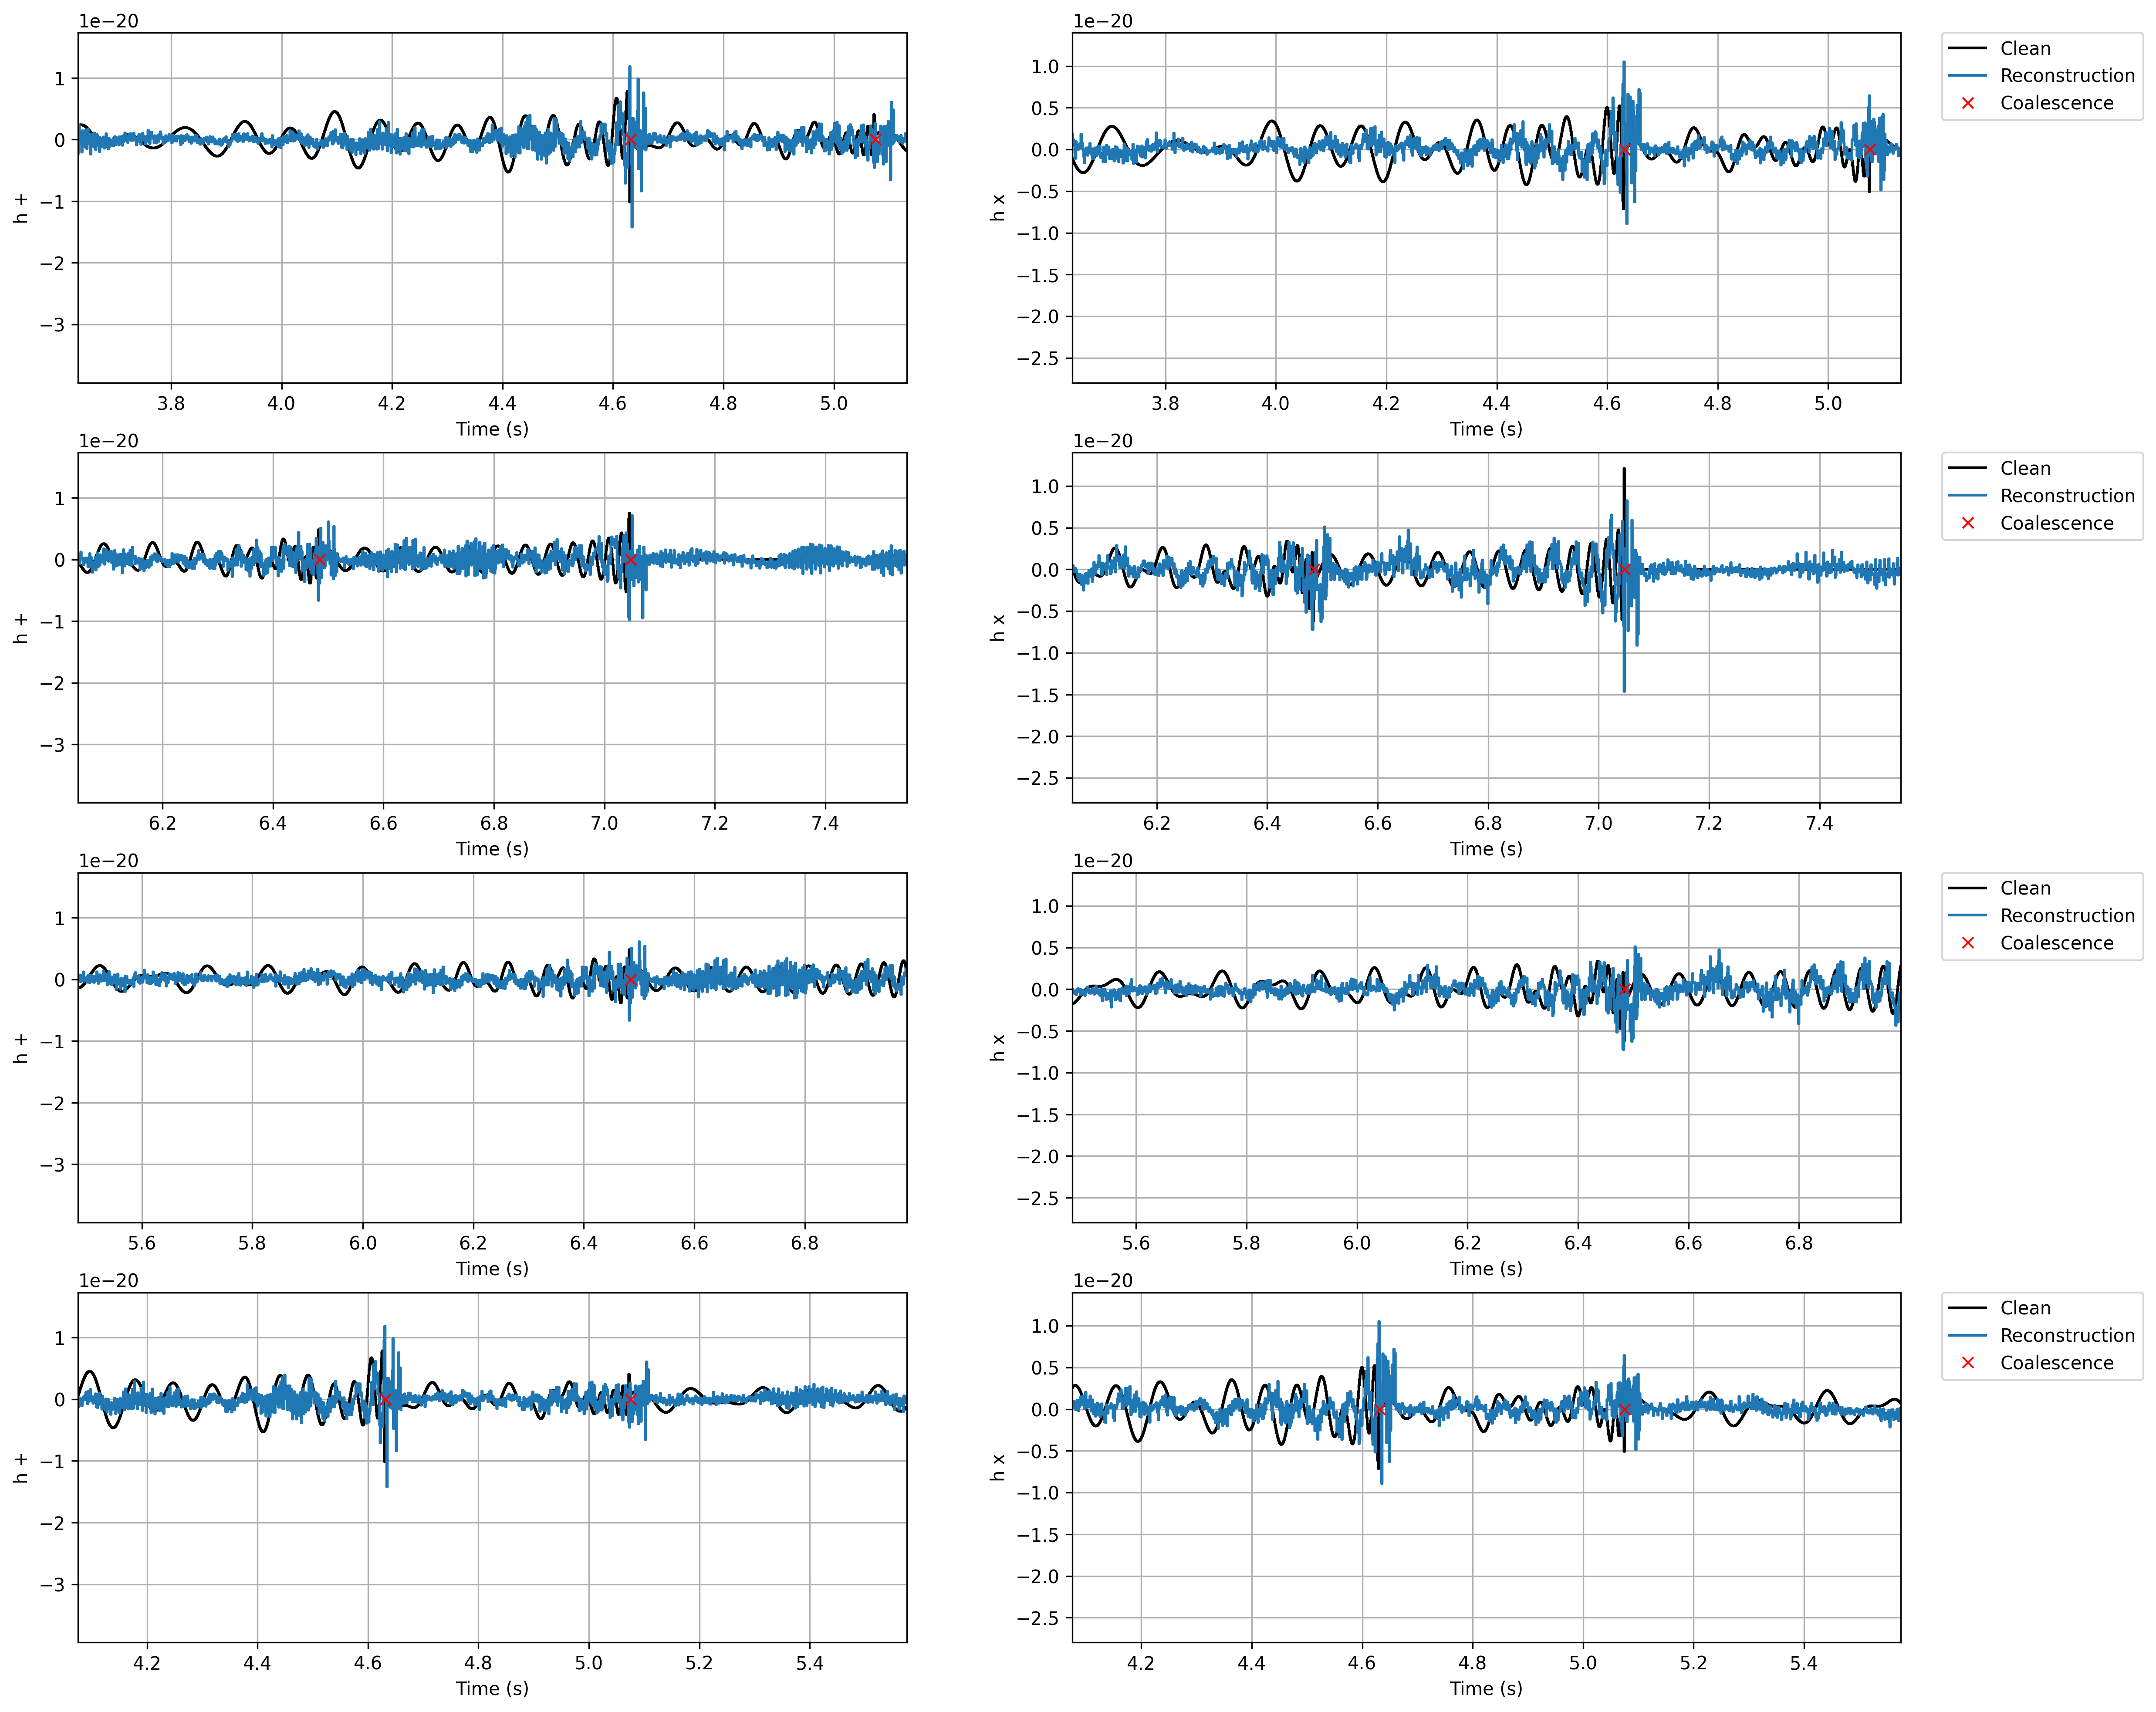

In [ ]:
plt.figure(figsize=(18, len(p.tcoal_s)*4), dpi=300)
for i, tcoal_s in enumerate(p.tcoal_s):
    plt.subplot(len(p.tcoal_s), 2, 2*i+1)
    plt.step(dataset.times, 1e-20*y[:, 0], "k", label="Clean")
    plt.step(dataset.times, 1e-20*out[:, 0], "tab:blue", label="Reconstruction")
    plt.plot(p.tcoal_s, jnp.zeros_like(p.tcoal_s), "rx", label="Coalescence")
    #plt.step(dataset.times, 1e-20*x[:, 0], "k", label="Noisy", alpha=0.2)   
    plt.xlim(tcoal_s-1.0, tcoal_s + 0.5)
    plt.ylabel("h +")
    plt.xlabel("Time (s)")
    plt.grid()

    plt.subplot(len(p.tcoal_s), 2, 2*i+2)
    plt.step(dataset.times, 1e-20*y[:, 1], "k", label="Clean")
    plt.step(dataset.times, 1e-20*out[:, 1], "tab:blue", label="Reconstruction")
    plt.plot(p.tcoal_s, jnp.zeros_like(p.tcoal_s), "rx", label="Coalescence")
    #plt.step(dataset.times, 1e-20*x[:, 1], "k", label="Noisy", alpha=0.2)
    plt.xlim(tcoal_s-1.0, tcoal_s + 0.5)
    plt.ylabel("h x")
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()